In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import sys
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [3]:
csv_train_loss_18 = "20250518_train_loss.csv"
csv_train_accuracy_18 = "20250518_train_accuracy.csv"
csv_train_duration_18 = "20250518_train_duration.csv"
csv_valid_loss_18 = "20250518_valid_loss.csv"
csv_valid_accuracy_18 = "20250518_valid_accuracy.csv"
csv_valid_duration_18 = "20250518_valid_duration.csv"

csv_train_loss_19 = "20250519_train_loss.csv"
csv_train_accuracy_19 = "20250519_train_accuracy.csv"
csv_train_duration_19 = "20250519_train_duration.csv"
csv_valid_loss_19 = "20250519_valid_loss.csv"
csv_valid_accuracy_19 = "20250519_valid_accuracy.csv"
csv_valid_duration_19 = "20250519_valid_duration.csv"

In [4]:
# pd.read_csv(csv_train_loss_18).columns

In [5]:
df_lookup = pd.DataFrame([
    [ "1", "20250518", "152548", 512, 128, 6, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "2", "20250518", "153151", 256, 128, 6, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "3", "20250518", "233656", 512, 256, 6, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "4", "20250518", "233931", 512, 256, 8, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "5", "20250518", "172719", 512, 256, 6, 1, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "6", "20250518", "172825", 512, 256, 10, 4, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "7", "20250518", "174841", 512, 256, 10, 8, 2, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "8", "20250518", "174943", 512, 256, 10, 8, 4, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    [ "9", "20250518", "235356", 512, 256, 10, 8, 8, "ReLu", "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["10", "20250518", "235535", 512, 256, 10, 8, 8, "GELU", "GELU", "scaled_dot", "Absolute", "A4500"],
    ["11", "20250519", "111436", 512, 256, 10, 8, 8, "SiLU", "SiLU", "scaled_dot", "Absolute", "A4500"],
    ["12", "20250519", "111753", 512, 256, 10, 8, 8, "SiLU", "SiLU", "xformers", "Absolute", "A4500"],
    ["13", "20250519", "112057", 512, 256, 10, 8, 8, "SiLU", "SiLU", "xformers", "ROPE", "A4500"],
    ["14", "20250519", "113232", 512, 256, 10, 8, 8, "SiLU", "SiLU", "AliBi", "AliBi", "A4500"],
    ["15", "20250519", "173628", 512, 256, 10, 8, 8, "SiLU", "SiLU", "T5", "T5", "A4500"],
    ["16", "20250519", "180656", 512, 256, 10, 8, 8, "SiLU", "SiLU", "scaled_dot", "ROPE", "A4500"],
    ["17", "20250521", "121428", 512, 256, 10, 8, 8, "GELU", "SiLU", "scaled_dot", "ROPE", "A4500"],
    ["18", "20250521", "121701", 512, 256, 10, 8, 8, "GELU", "SiLU", "AliBi", "AliBi", "A4500"],
    ["19", "20250521", "122145", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
    ["20", "20250521", "170426", 512, 256, 10, 8, 8, "GELU", "GELU", "T5", "T5", "A4500"],
    ["21", "20250521", "205239", 512, 256, 10, 8, 8, "GELU", "GELU", "scaled_dot", "ROPE", "A4500"],
    ["22", "20250521", "220634", 512, 256, 10, 8, 8, "GELU", "GELU", "AliBi", "AliBi", "A4500"],
    ["23", "20250521", "122145", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
    ["24", "20250521", "122145", 512, 256, 10, 8, 8, "GELU", "SiLU", "T5", "T5", "A4500"],
], columns=[
    "runID","date", "time", "d_model", "seq_len", "n_layers", "n_heads", "n_output_layers",
    "FFNN_activation", "out_activation", "attention", "position_encoding", "GPU"
])


In [6]:
def extract_columns(df: pd.DataFrame, endswith: str):
    cols = [col for col in df.columns if col.endswith(endswith)]
    df_filtered = df[cols].copy()
    df_filtered.columns = [col.split(' ')[0] for col in cols]
    return df_filtered

def extract_loss_columns(df):
    return extract_columns(df, '_loss')
def extract_accuracy_columns(df):
    return extract_columns(df, '_accuracy')
def extract_duration_columns(df):
    return extract_columns(df, '_duration')

In [7]:
extract_loss_columns(pd.read_csv(csv_train_loss_18)).columns

Index(['235535', '235356', '233931', '233656', '174943', '174841', '172825',
       '172719', '153151', '152548'],
      dtype='object')

In [8]:
# extract_loss_columns(pd.read_csv(csv_valid_loss_18))

In [9]:
def process_and_rename_columns(
    file_paths: list[str],
    extractor_fn,
    lookup_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Load CSVs, extract relevant columns, merge them, and rename columns
    from time to runID based on the lookup table.
    """
    # Load and merge
    dfs = [extractor_fn(pd.read_csv(path)) for path in file_paths]
    merged_df = pd.concat(dfs, axis=1)

    # Rename time-based columns to runID
    time_to_runID = dict(zip(lookup_df["time"], lookup_df["runID"]))
    merged_df = merged_df.rename(columns=lambda x: time_to_runID.get(x, x))

    return merged_df


In [10]:
merged_train_loss = process_and_rename_columns(
    [csv_train_loss_18, csv_train_loss_19],
    extract_loss_columns,
    df_lookup
)
merged_train_accuracy = process_and_rename_columns(
    [csv_train_accuracy_18, csv_train_accuracy_19],
    extract_accuracy_columns,
    df_lookup
)
merged_train_duration = process_and_rename_columns(
    [csv_train_duration_18, csv_train_duration_19],
    extract_duration_columns,
    df_lookup
)
merged_valid_loss = process_and_rename_columns(
    [csv_valid_loss_18, csv_valid_loss_19],
    extract_loss_columns,
    df_lookup
)
merged_valid_accuracy = process_and_rename_columns(
    [csv_valid_accuracy_18, csv_valid_accuracy_19],
    extract_accuracy_columns,
    df_lookup
)


In [11]:
merged_valid_loss

,10,9,4,3,8,7,6,5,2,1,16,15,14,13,12,11
0,0.161026,0.169993,0.185437,0.174134,0.172561,0.183065,0.176422,0.168699,0.171297,0.176140,0.153421,0.147933,0.152803,0.149594,0.163583,0.169504
1,0.168975,0.158755,0.163639,0.158870,0.153765,0.162360,0.157250,0.155583,0.163733,0.162313,0.133788,0.137476,0.137039,0.138195,0.163989,0.168226
2,0.160396,0.147349,0.145391,0.148425,0.142801,0.143852,0.143938,0.148154,0.154443,0.158819,0.127857,0.134372,0.135726,0.129747,0.146569,0.156773
3,0.139035,0.136413,0.133921,0.137158,0.134585,0.135132,0.134270,0.139639,0.149010,0.150764,0.125231,0.134125,0.127994,0.138389,0.141232,0.147342
4,0.137540,0.134225,0.134855,0.133616,0.131379,0.133619,0.132718,0.135950,0.141635,0.137304,0.118681,0.127663,0.124860,0.120498,0.133921,0.134653
5,0.126854,0.138077,0.131058,0.127427,0.126226,0.128898,0.129640,0.134386,0.139404,0.136101,0.120463,0.120865,0.122296,0.118619,0.128680,0.129970
6,0.125823,0.132792,0.128411,0.126524,0.127557,0.128445,0.129037,0.129333,0.138559,0.135216,0.120368,0.116032,0.122614,0.120583,0.126291,0.128019
7,0.123739,0.125933,0.128331,0.127353,0.128435,0.126394,0.128313,0.127956,0.137556,0.134610,0.115643,0.116550,0.120808,0.118187,0.129448,0.127156
8,0.123646,0.125647,0.126493,0.129313,0.124299,0.134908,0.123361,0.130781,0.133438,0.133752,0.115914,0.114413,0.120170,0.116534,0.123454,0.123409
9,0.123799,0.124134,0.125376,0.125838,0.124623,0.127421,0.123907,0.125102,0.134370,0.133301,0.122686,0.117328,0.118402,0.114806,0.123688,0.121975


In [12]:
merged_train_loss.columns

Index(['10', '9', '4', '3', '8', '7', '6', '5', '2', '1', '16', '15', '14',
       '13', '12', '11'],
      dtype='object')

In [13]:
def get_label(run_id, lookup_df):
    row = lookup_df.loc[lookup_df["runID"] == run_id]
    if row.empty:
        return f"RunID {run_id}"

    d_model = row["d_model"].values[0]
    attn = row["attention"].values[0]
    n_layers = row["n_layers"].values[0]

    # Example label
    return f"Run{run_id} | d={d_model}, layers={n_layers}, attn={attn}"


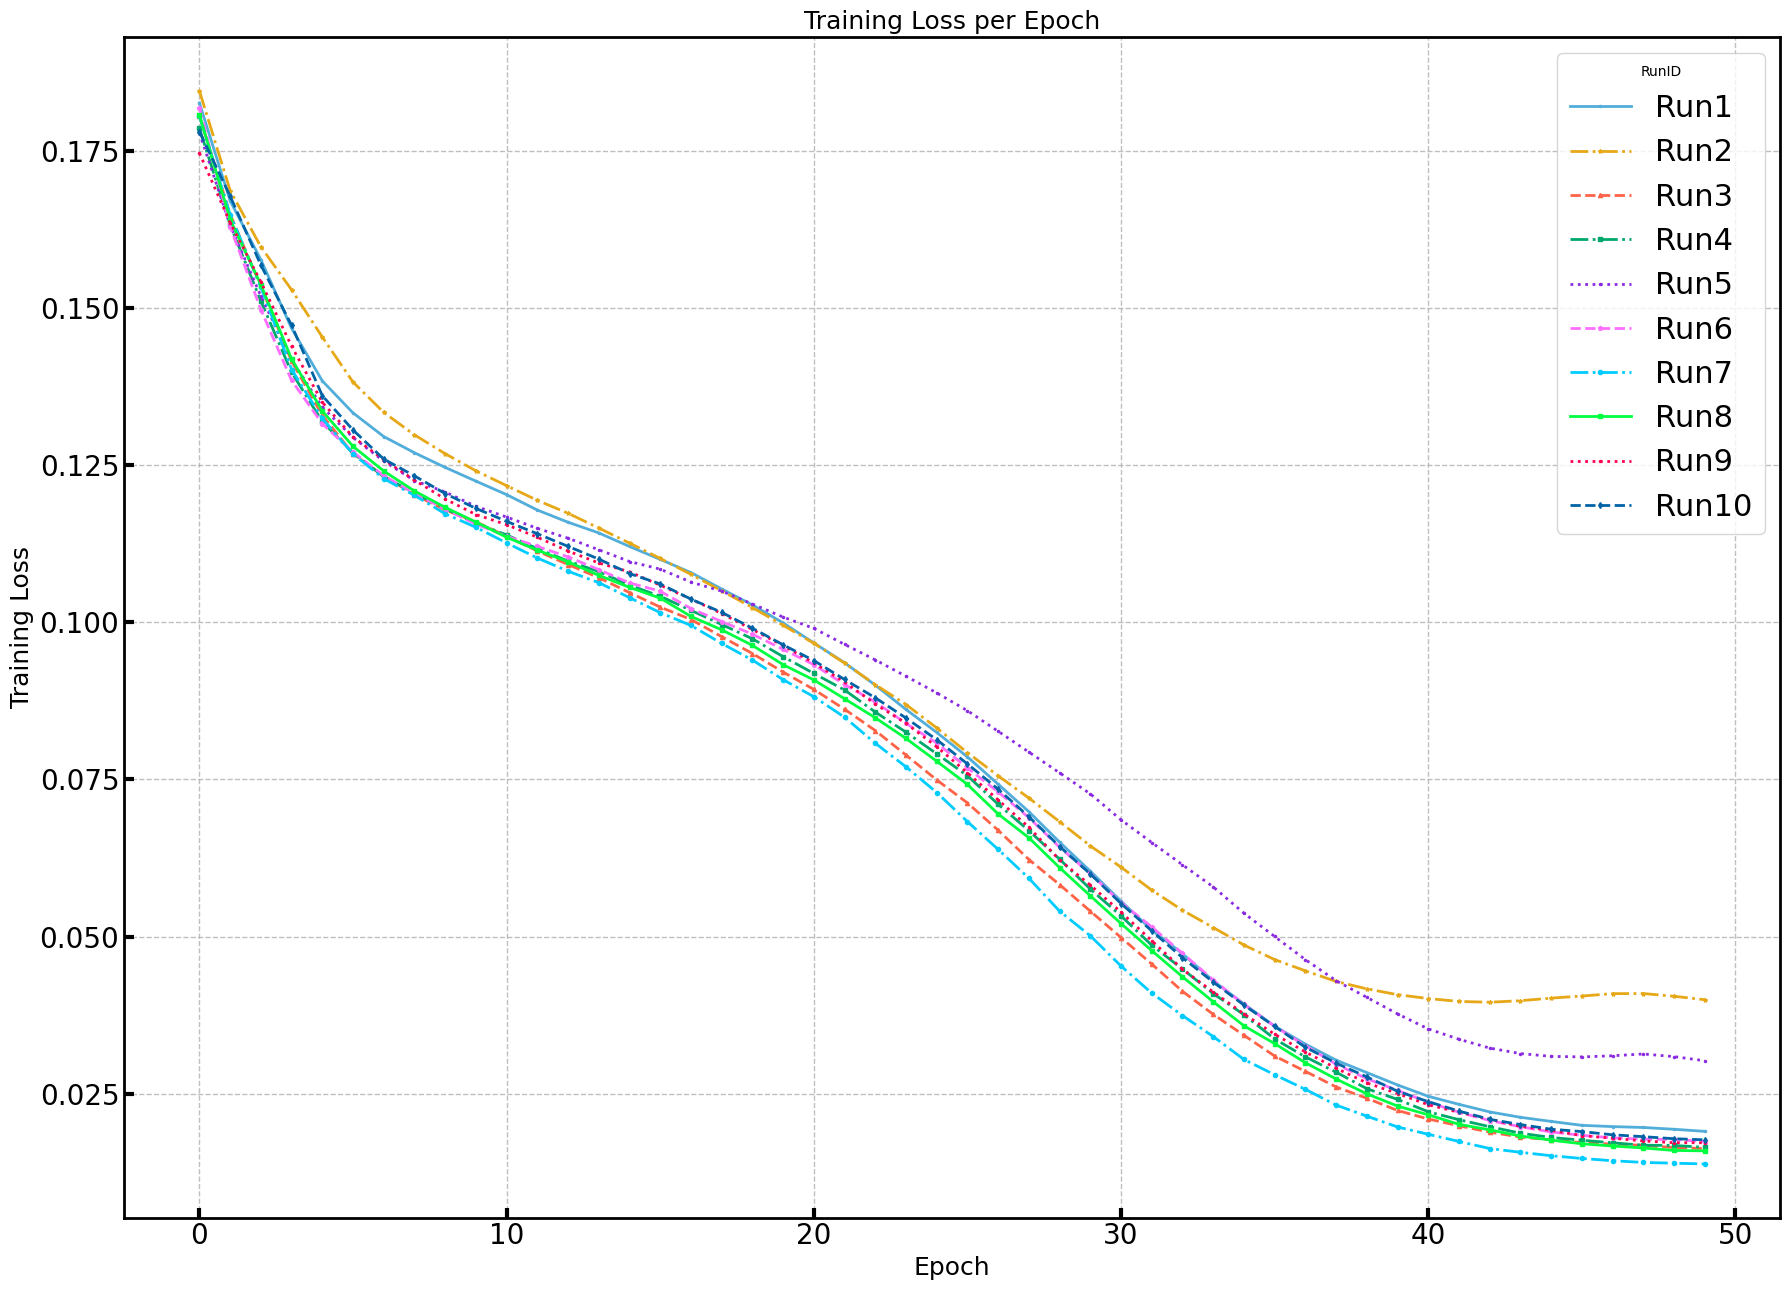

In [14]:
def plot_train_loss(merged_df: pd.DataFrame, lookup_df: pd.DataFrame, selected_id: list[str] = None):
    """
    Plot training loss over epochs using runID as the selection and label.

    Parameters:
    - merged_df: DataFrame with training loss values. Columns should be runIDs.
    - lookup_df: DataFrame with the configuration lookup.
    - selected_id: Optional list of runIDs to plot (strings).
    """
    if selected_id is None:
        selected_id = merged_df.columns.tolist()

    fig, ax = plt.subplots(figsize=(18, 13))

    for run_id in selected_id:
        if run_id not in merged_df.columns:
            print(f"[Warning] RunID {run_id} not found in DataFrame columns. Skipping.")
            continue

        label = f"Run{run_id}"
        ax.plot(merged_df.index, merged_df[run_id], label=label)

    ax.set_title("Training Loss per Epoch", fontsize=18)
    ax.set_xlabel("Epoch", fontsize=18)
    ax.set_ylabel("Training Loss", fontsize=18)
    ax.legend(title="RunID", fontsize=22)
    plt.tight_layout()
    plt.show()
plot_train_loss(merged_train_loss, lookup_df=df_lookup, selected_id=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])    

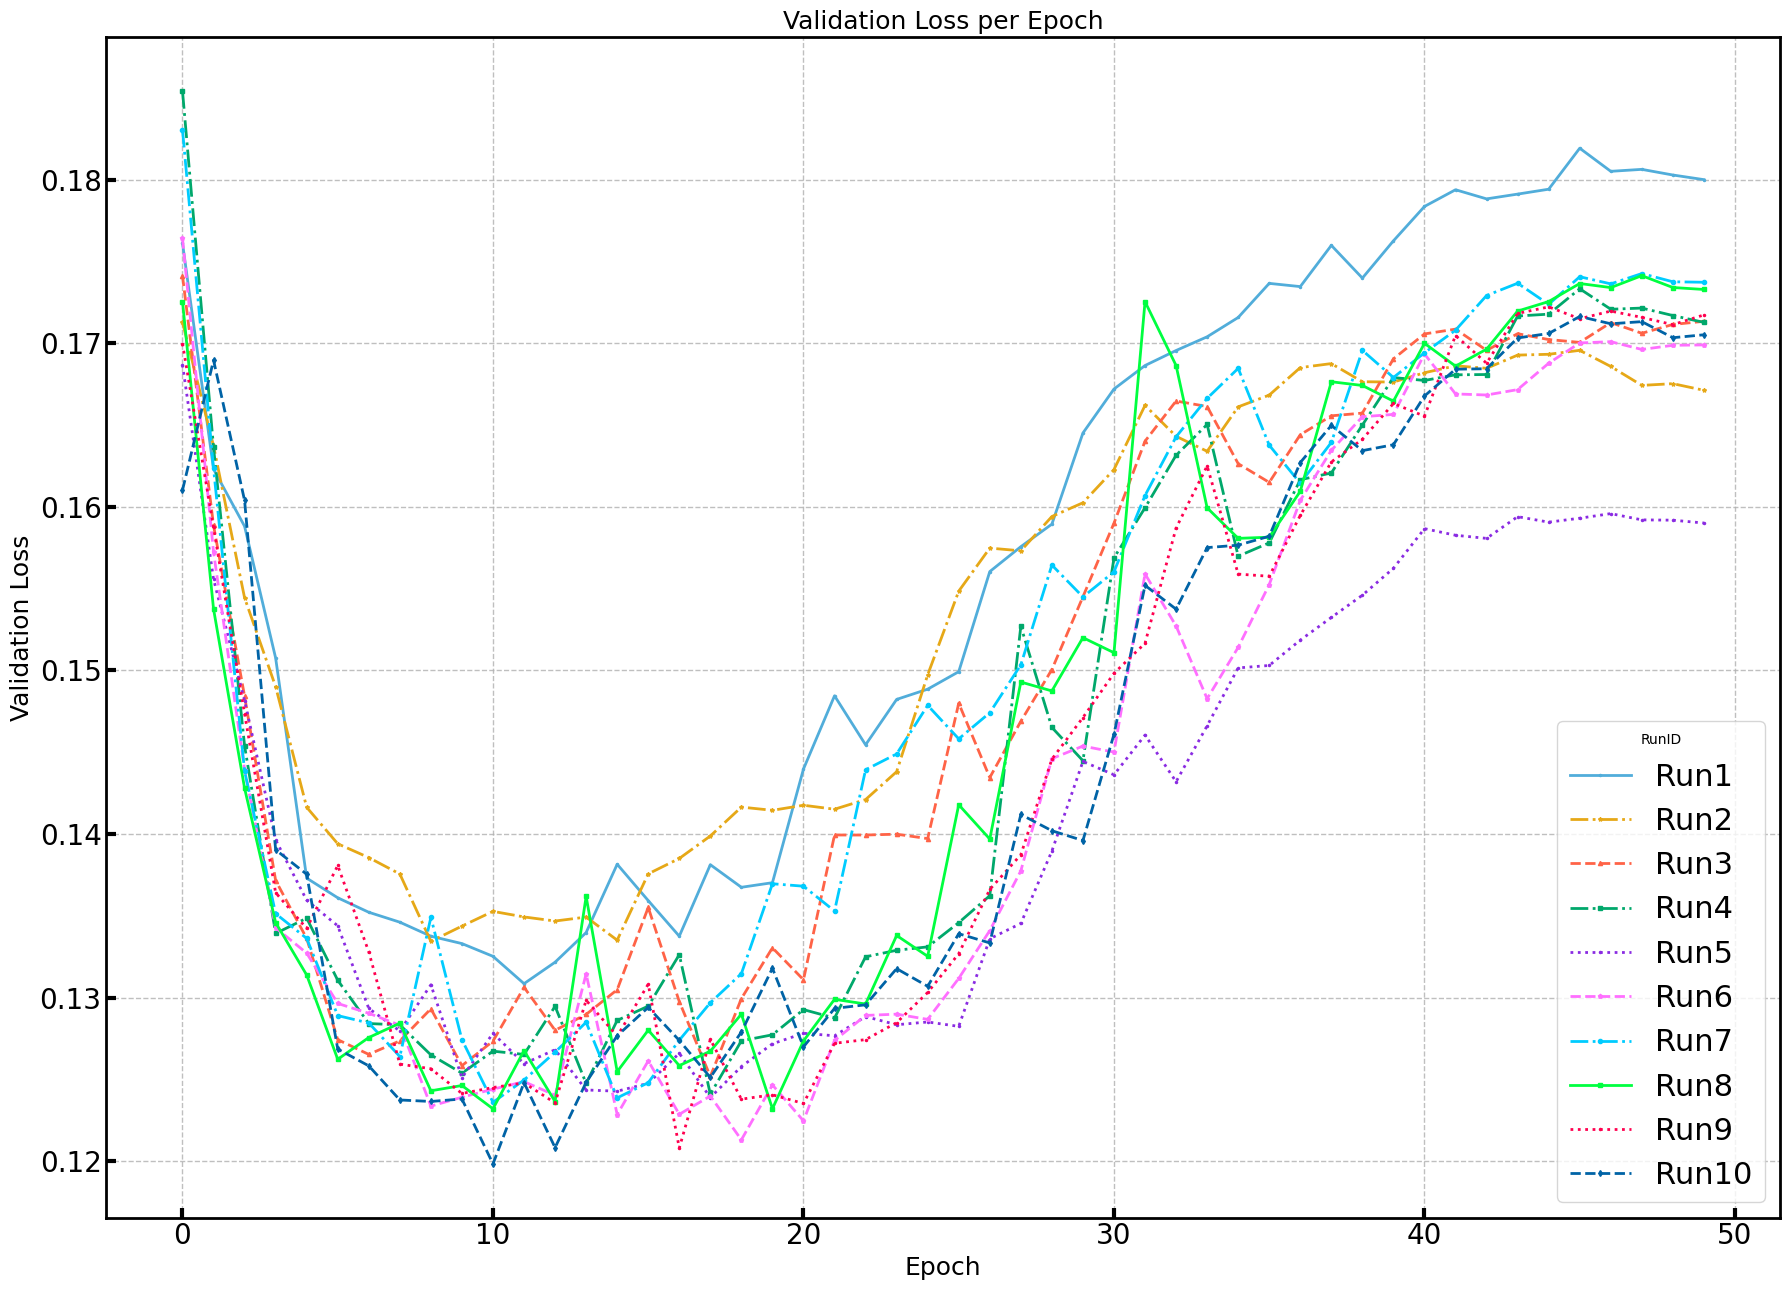

In [15]:
def plot_validation_loss(merged_df: pd.DataFrame, lookup_df: pd.DataFrame, selected_id: list[str] = None):
    if selected_id is None:
        selected_id = merged_df.columns.tolist()
    
    fig, ax = plt.subplots(figsize=(18, 13))
    
    for run_id in selected_id:
        if run_id not in merged_df.columns:
            print(f"[Warning] RunID {run_id} not found in DataFrame columns. Skipping.")
            continue

        label = f"Run{run_id}"
        ax.plot(merged_df.index, merged_df[run_id], label=label)

    ax.set_title("Validation Loss per Epoch", fontsize=18)
    ax.set_xlabel("Epoch", fontsize=18)
    ax.set_ylabel("Validation Loss", fontsize=18)
    ax.legend(title="RunID", fontsize=22)
    plt.tight_layout()
    plt.show()
plot_validation_loss(merged_valid_loss, lookup_df=df_lookup, selected_id=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

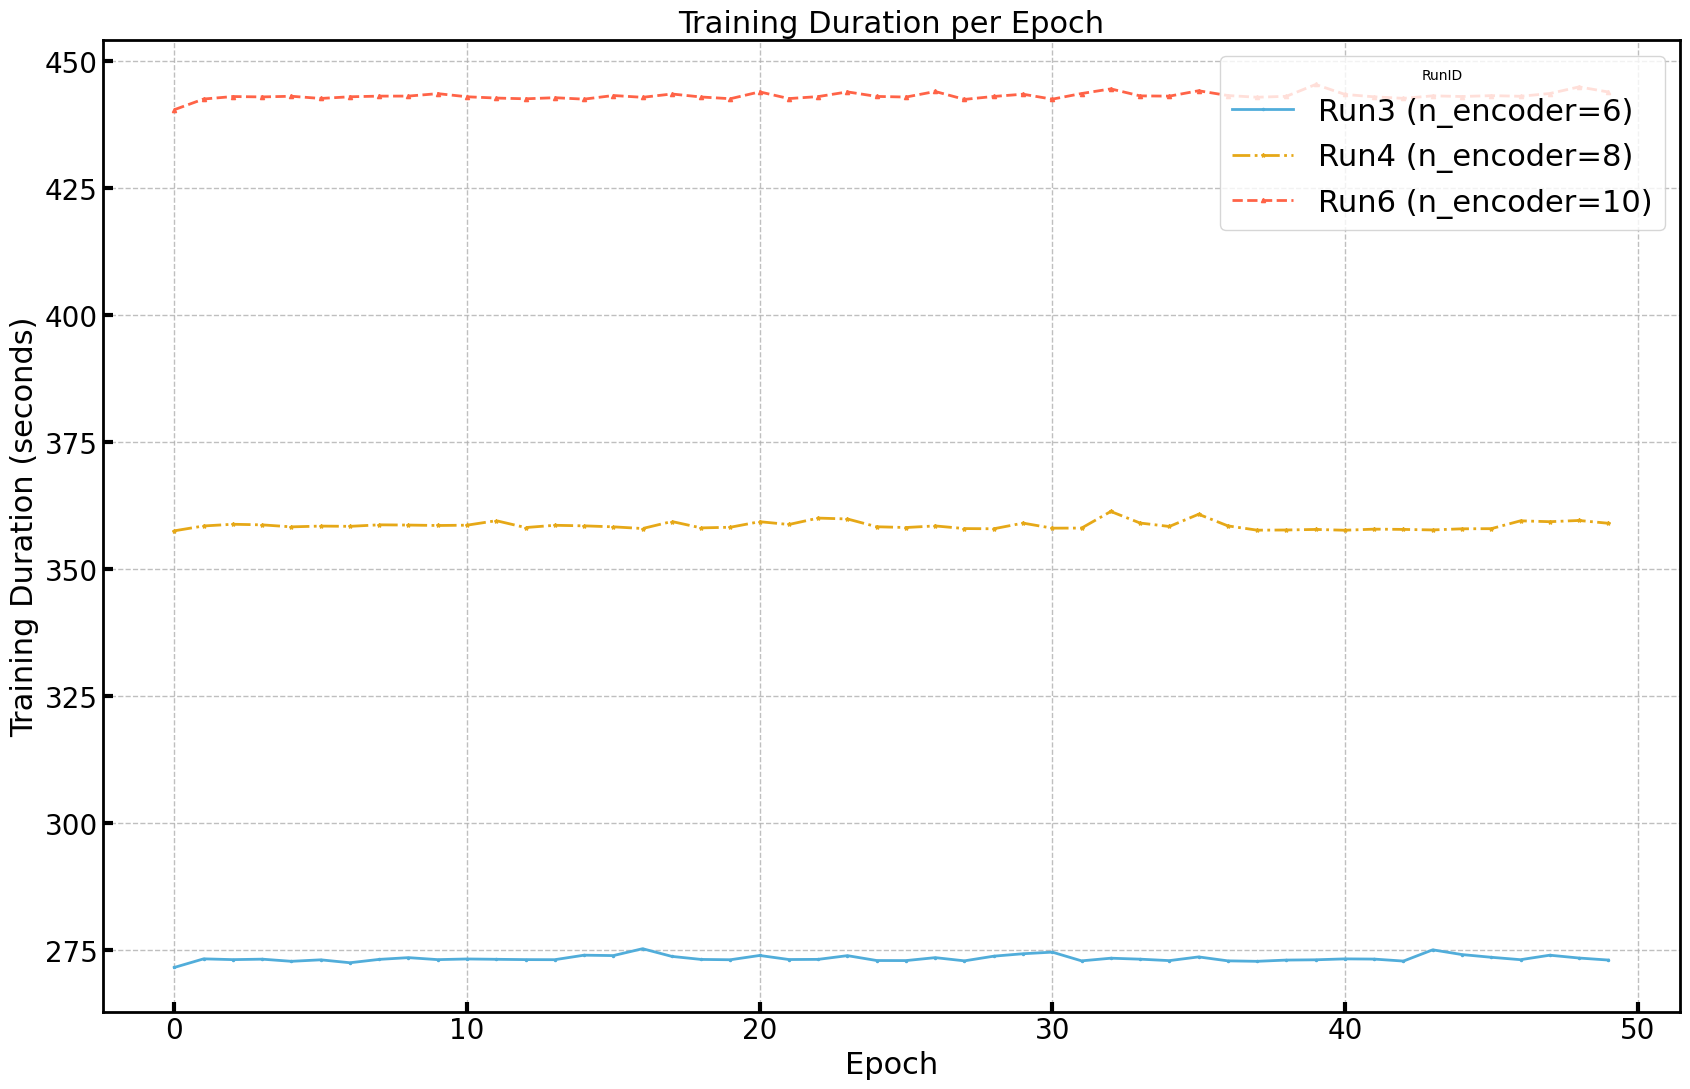

In [16]:
def plot_train_duration(
    merged_df: pd.DataFrame,
    lookup_df: pd.DataFrame,
    selected_id: list[str] = None,
    custom_labels: dict = None
):
    if selected_id is None:
        selected_id = merged_df.columns.tolist()

    # Convert all selected IDs to strings for matching with column names
    selected_id = [str(rid) for rid in selected_id]

    fig, ax = plt.subplots(figsize=(17, 11))

    for run_id in selected_id:
        if run_id not in merged_df.columns:
            print(f"[Warning] RunID {run_id} not found in DataFrame columns. Skipping.")
            continue

        # Use custom label if provided, otherwise fallback to default label
        if custom_labels and run_id in custom_labels:
            label = custom_labels[run_id]
        else:
            label = f"Run{run_id}"

        ax.plot(merged_df.index, merged_df[run_id], label=label)

    ax.set_title("Training Duration per Epoch", fontsize=22)
    ax.set_xlabel("Epoch", fontsize=22)
    ax.set_ylabel("Training Duration (seconds)", fontsize=22)
    ax.legend(title="RunID", fontsize=22)
    plt.tight_layout()
    plt.show()
plot_train_duration(
    merged_train_duration,
    lookup_df=df_lookup,
    selected_id=["3", "4", "6"],
    custom_labels={
        "3": "Run3 (n_encoder=6)",
        "4": "Run4 (n_encoder=8)",
        "6": "Run6 (n_encoder=10)"
    }
)


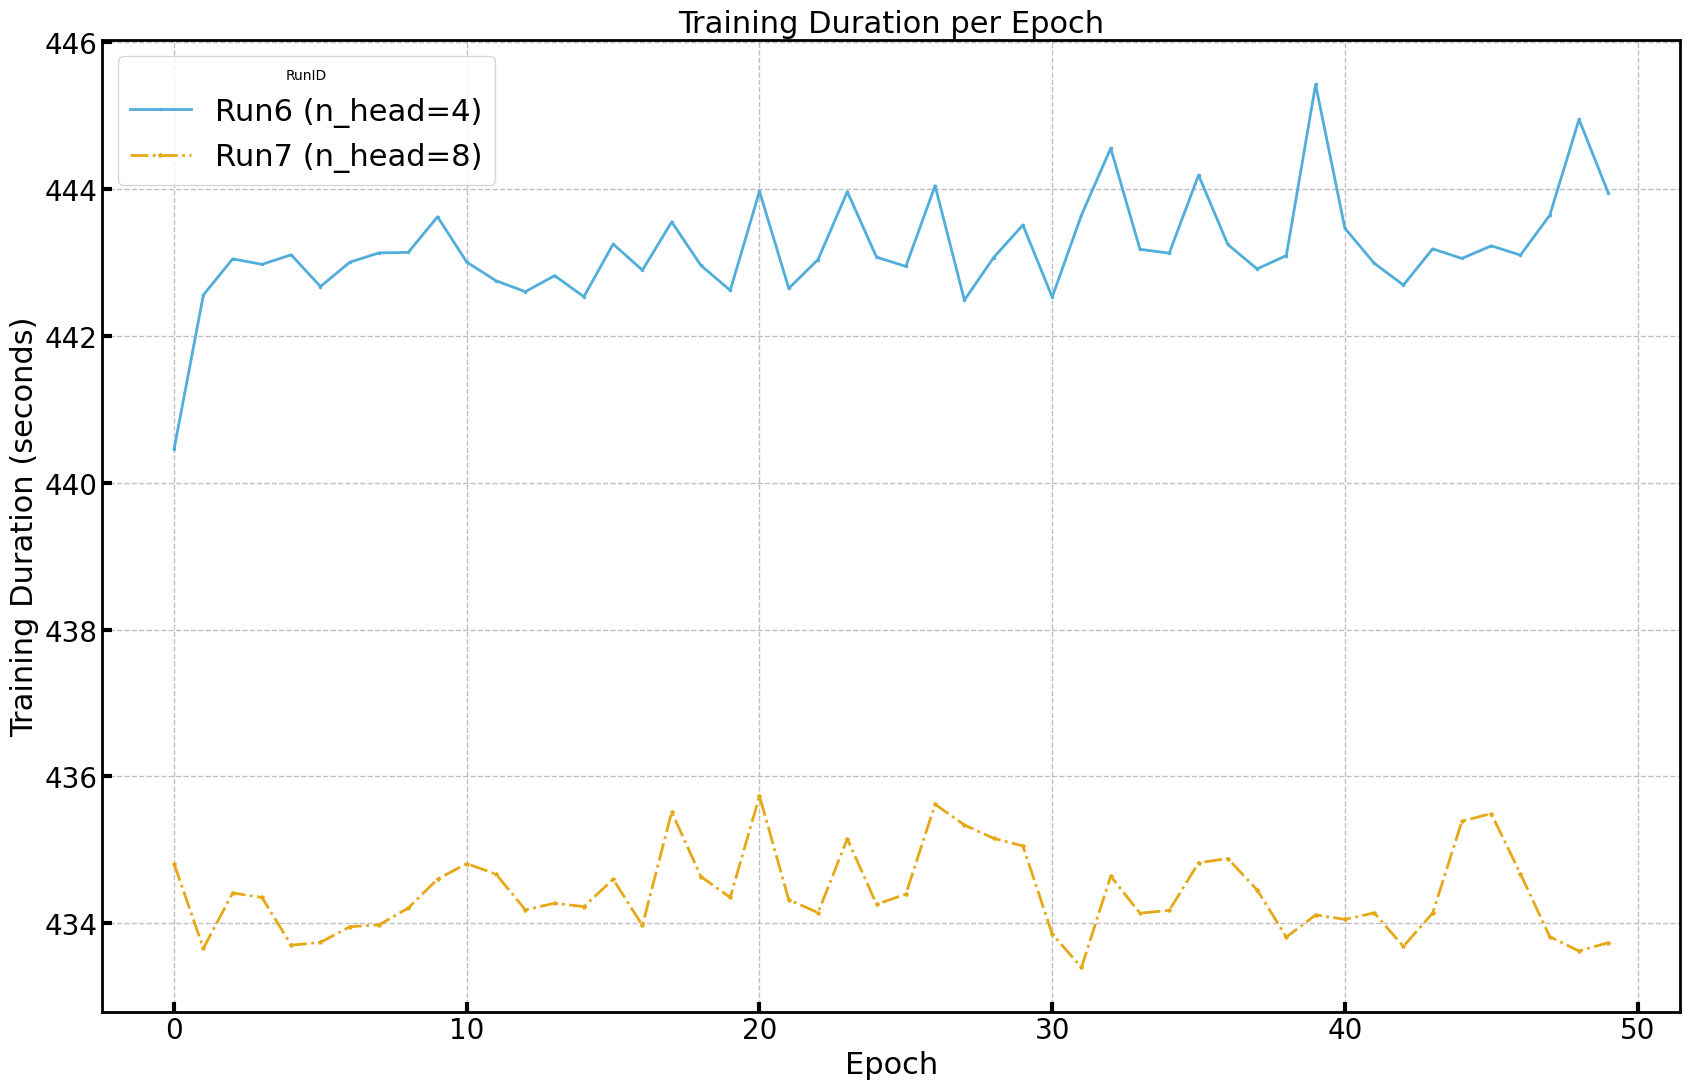

In [17]:
plot_train_duration(
    merged_train_duration,
    lookup_df=df_lookup,
    selected_id=["6","7"],
    custom_labels={
        "6": "Run6 (n_head=4)",
        "7": "Run7 (n_head=8)"
    }
)

In [18]:

def plot_onecycle_configs(configs, steps_per_epoch=100, epochs=10):
    fig, ax = plt.subplots(figsize=(17, 11))

    for cfg in configs:
        model = torch.nn.Linear(1, 1)  # dummy model
        optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)

        scheduler = OneCycleLR(
            optimizer,
            max_lr=cfg.get("max_lr", 0.1),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            pct_start=cfg.get("pct_start", 0.3),
            anneal_strategy=cfg.get("anneal_strategy", 'cos'),
            div_factor=cfg.get("div_factor", 25.0),
            final_div_factor=cfg.get("final_div_factor", 1e4),
            three_phase=cfg.get("three_phase", False)
        )

        lrs = []
        for _ in range(steps_per_epoch * epochs):
            optimizer.step()
            lrs.append(optimizer.param_groups[0]['lr'])
            scheduler.step()

        label = cfg.get("label", str(cfg))
        ax.plot(lrs, label=label, linewidth=2)

    ax.set_title("OneCycleLR Learning Rate Schedules")
    ax.set_xlabel("Step", fontsize=22)
    ax.set_ylabel("Learning Rate", fontsize=22)
    ax.legend(fontsize=24)
    plt.tight_layout()
    plt.show()


In [19]:
configs = [
    {"max_lr": 1e-4, "pct_start": 0.1, "div_factor": 5, "final_div_factor": 100, "label": "max_lr(1e-4),pct_start(0.1), div(5), final(100)"},
    # {"max_lr": 3e-4, "pct_start": 0.1, "div_factor": 25, "final_div_factor": 100, "label": "max_lr(3e-4),pct_start(0.1), div(25), final(100)"},
    # {"max_lr": 1e-4, "pct_start": 0.3, "div_factor": 100, "final_div_factor": 1e4, "label": "max_lr(1e-4),pct_start(0.3), div(100), final(1e4)"},
    # {"max_lr": 3e-4, "pct_start": 0.05, "div_factor": 100, "final_div_factor": 1e4, "label": "max_lr(3e-4),pct_start(0.05), div(100), final(1e4)"},
]

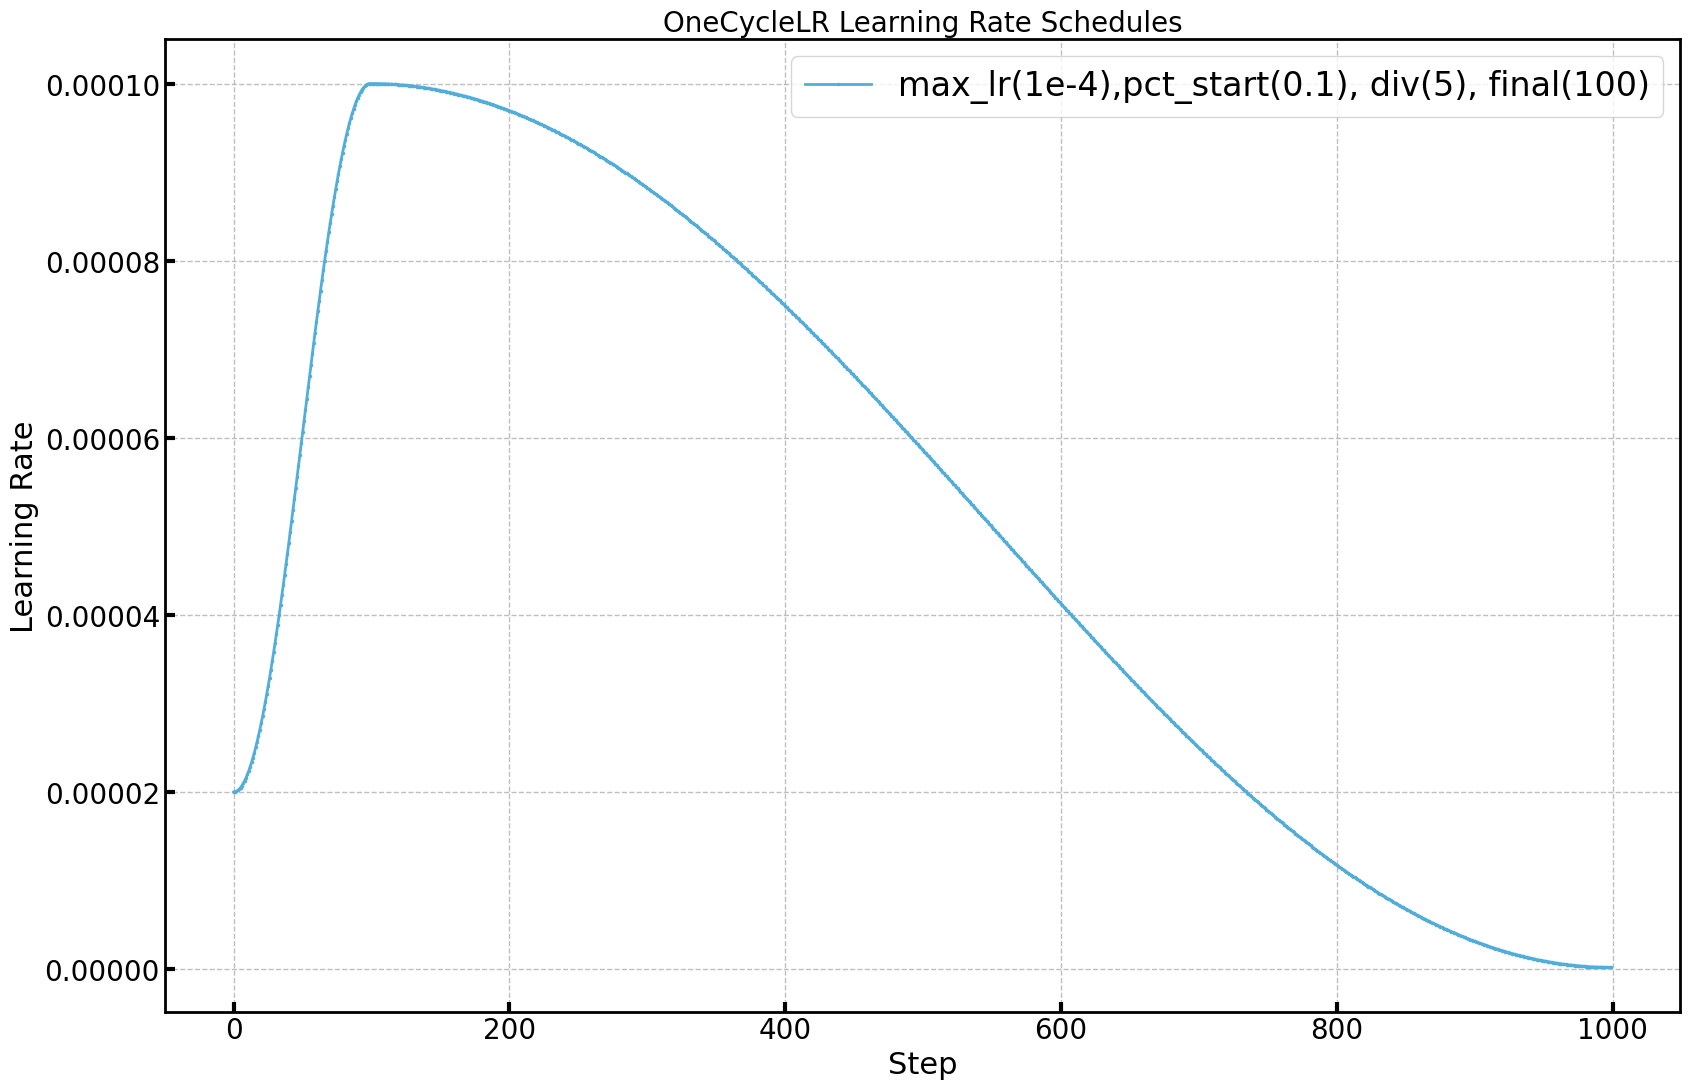

In [20]:
plot_onecycle_configs(configs, steps_per_epoch=100, epochs=10)